In [204]:
import dill

#dill.dump_session("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/Intermediate_Data/AccessNetwork_20210406.pkl")
#dill.load_session("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/Intermediate_Data/AccessNetwork_20210406.pkl")

### Comparing foot pattern statistics with demographic makeup of CBGs

In [15]:
# Import libraries
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import numpy as np
from hagerstrand import dataprocess
from hagerstrand import *

In [29]:
# Load in stores dataset
stores = pd.read_csv(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\Safegraph_GroceryStores_Patterns_Dec_2020_Feb_2021\February 2021 Activity\core_poi-geometry-patterns-sgpid.csv", index_col=0)

# Extend data frames with custom class and functions
stores_edf = dataprocess.ExtendedDataFrame(stores.copy())

# Remove duplicate entries
stores_edf = stores_edf.deduplicate(["customer_FullAddress"])

# Unpack json column containing cbg and number of respective visitors
safegraph_unpack = stores_edf.jsoncol_merge()

# Set CBG column to string
safegraph_unpack["visitor_home_cbg"] = safegraph_unpack["visitor_home_cbg"].astype(str)

In [30]:
# Clean up new unpacked json of patterns into original stores df
safegraph_unpack.rename(columns={"Unnamed: 0": "StoreID"}, inplace=True)
safegraph_unpack = pd.DataFrame(safegraph_unpack)

In [17]:
# Obtain the centroid of each census block group polygon and return as a GeoPandasDataFrame
points = poly_centroid(r"C:\Users\jfeng\OneDrive - University of Tennessee\Research\Information Geography\Data\KnoxCountyBlockGroup.shp", 6576, True, 4326)
# Read in a shapefile of Knox County as a GeoPandasDataFrame 
poly = gpd.read_file(r"C:\Users\jfeng\OneDrive - University of Tennessee\Research\Information Geography\Data\KnoxCountyBlockGroup.shp")

The coordinate system for the centroids is: epsg:4326
The coordinate system for the polygons is: epsg:4326


c:\users\jfeng\hagerstrand\hagerstrand\hagerstrand.py:263: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid


In [31]:
# Filter out only rows of unpacked patterns dataset in which the visitor home CBG is in Knox County, Tennessee
sg_filter = safegraph_unpack[safegraph_unpack["visitor_home_cbg"].isin(poly["GEOID"])]
# Save to csv
#sg_filter.to_csv("C:/Users/jfeng/hagerstrand/examples/data/core_poi-patterns_knox.csv")
# Aggregate the number of different stores visited by each CBG
knox_cbg_numstores = sg_filter.groupby("visitor_home_cbg").agg({"customer_PlusCode": ['count']})
# Reset index of new data frame for aggregated stores visited per CBG
knox_cbg_numstores.columns = knox_cbg_numstores.columns.droplevel(0)
knox_cbg_numstores = knox_cbg_numstores.reset_index()
knox_cbg_numstores

,visitor_home_cbg,count
0,470930001001,11
1,470930008001,10
2,470930008002,9
3,470930008003,13
4,470930009011,8
...,...,...
237,470930070001,13
238,470930070002,4
239,470930071001,8
240,470930071002,5


In [2]:
# Load in demographic and socioeconomic characteristics for each CBG in Knox County, Tennessee
knox_cbg = gpd.read_file("../../examples/data/KnoxCountyCBG_Demographics.shp")
knox_cbg = knox_cbg.rename(columns={
    "raceandhis":"Asian",
    "raceandhi0":"AsianPer",
    "raceandhi1":"Black",
    "raceandhi2":"BlackPer",
    "raceandhi3":"White",
    "raceandhi4":"WhitePer",
    "raceandhi5":"Hispanic",
    "raceandhi6":"HispanicPer",
    "households":"HHBelowPov",
    "household0":"HHBelowPer",
    "foodstamp0":"SNAPPer",
    "householdi":"MedIncome",
    "household1":"AvgIncome",
})
print(knox_cbg.crs)
knox_cbg.head(5)

epsg:6576


,OBJECTID,GEOID,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,SHAPE_Leng,SHAPE_Area,aggregatio,...,WhitePer,Hispanic,HispanicPer,HHBelowPov,HHBelowPer,foodstamps,SNAPPer,MedIncome,AvgIncome,geometry
0,1777,470930001001,Block Group 1,1470165.0,61951.0,+35.9649895,-83.9203408,19149.867630,1.648985e+07,BlockApportionment:US.BlockGroups,...,85.77,54,2.36,424,29.20,305,21.01,44587,68941,"POLYGON ((2581081.934 601658.291, 2581166.747 ..."
1,1778,470930008001,Block Group 1,755181.0,0.0,+35.9545461,-83.9011488,12131.642080,8.127871e+06,BlockApportionment:US.BlockGroups,...,63.46,65,3.95,379,46.56,165,20.27,23801,33329,"POLYGON ((2587611.808 597980.673, 2587923.650 ..."
2,1779,470930008002,Block Group 2,1062736.0,297306.0,+35.9583565,-83.9012011,23747.020887,1.463784e+07,BlockApportionment:US.BlockGroups,...,77.85,111,7.84,34,15.04,54,23.89,40169,53452,"POLYGON ((2584454.497 597727.651, 2584503.141 ..."
3,1780,470930008003,Block Group 3,786973.0,0.0,+35.9526806,-83.9099419,13094.176069,8.470041e+06,BlockApportionment:US.BlockGroups,...,87.10,70,4.83,191,49.35,8,2.07,16282,26076,"POLYGON ((2585135.857 596647.304, 2585191.670 ..."
4,1781,470930009011,Block Group 1,690041.0,113686.0,+35.9542093,-83.9245548,15946.172171,8.650365e+06,BlockApportionment:US.BlockGroups,...,72.89,74,4.20,0,0.00,0,0.00,12857,18614,"POLYGON ((2580244.925 597663.904, 2580842.581 ..."


In [37]:
# Layer of driving time from each CBG centroid to each store in and around Knox County
# Each row is for one origin CBG to one destination store 
knox_cbg_store_drive = pd.read_csv("../../examples/data/cbg_store_drivetime.csv", index_col=0, header=0)
# Set CBG column to string
knox_cbg_store_drive["CBG"] = knox_cbg_store_drive["CBG"].astype(str) 
# Merge driving time df with rows in the unpacked safegraph patterns dataset based on their common CBG and store combination 
knox_cbg_store_drive = pd.merge(knox_cbg_store_drive, sg_filter, left_on=["CBG","PlusCode"], right_on=["visitor_home_cbg","customer_PlusCode"])

In [38]:
knox_cbg_store_drive

,CBG,PlusCode,DestinationID,Total_TravelTime,Total_Kilometers,customer_Title,customer_StreetAddress,customer_FullAddress,customer_NumReviews,customer_PlusCode,...,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,visitor_home_cbg,cbg_visitor_name
0,470930001001,"X3JC+HQ Knoxville, Tennessee",74,4.612202,3.112122,Three Rivers Market,1100 N Central St,"1100 N Central St, Knoxville, TN 37917",886,"X3JC+HQ Knoxville, Tennessee",...,10312.0,14.0,"{""<5"":18,""5-10"":124,""11-20"":71,""21-60"":91,""61-...","{""Dollar General"":18,""Walmart"":18,""Whole Foods...","{""Kroger"":38,""Walmart"":31,""Chick-fil-A"":31,""We...","[1,0,0,0,1,6,20,30,23,24,45,72,73,66,72,61,40,...","{""Monday"":57,""Tuesday"":57,""Wednesday"":51,""Thur...","{""android"":94,""ios"":103}",470930001001,4
1,470930001001,"W3X6+X5 Knoxville, Tennessee",49,7.830585,4.715919,Publix Super Market at University Commons,2429 University Commons Way,"2429 University Commons Way, Knoxville, TN 37919",501,"W3X6+X5 Knoxville, Tennessee",...,12563.0,32.0,"{""<5"":2,""5-10"":29,""11-20"":35,""21-60"":79,""61-12...","{""Walmart"":93,""Simon mall"":20,""Graduate Hotels...","{""Walmart"":83,""Jersey Mike's"":36,""Weigel's"":35...","[0,0,0,0,20,23,28,19,24,26,33,47,59,46,42,26,2...","{""Monday"":22,""Tuesday"":26,""Wednesday"":20,""Thur...","{""android"":79,""ios"":40}",470930001001,4
2,470930001001,"WXMM+6Q Knoxville, Tennessee",64,10.576956,10.822680,Whole Foods Market,6730 Papermill Dr NW,"6730 Papermill Dr NW, Knoxville, TN 37919",1126,"WXMM+6Q Knoxville, Tennessee",...,15180.0,19.0,"{""<5"":30,""5-10"":333,""11-20"":283,""21-60"":451,""6...","{""Kroger"":11,""Cracker Barrel"":9,""Sam's Club"":7...","{""Weigel's"":38,""Target"":37,""Chick-fil-A"":37,""W...","[0,0,0,1,2,2,3,16,31,58,81,119,169,197,188,211...","{""Monday"":138,""Tuesday"":118,""Wednesday"":140,""T...","{""android"":340,""ios"":526}",470930001001,4
3,470930001001,"W2P6+V5 Knoxville, Tennessee",48,11.598550,9.524928,ALDI,5220 Kingston Pike,"5220 Kingston Pike, Knoxville, TN 37919",713,"W2P6+V5 Knoxville, Tennessee",...,8299.0,20.0,"{""<5"":13,""5-10"":145,""11-20"":123,""21-60"":225,""6...","{""Starbucks"":20,""Chick-fil-A"":13,""The Fresh Ma...","{""Chick-fil-A"":48,""Walmart"":44,""Weigel's"":37,""...","[0,0,0,0,0,0,0,0,6,40,51,48,70,73,82,127,132,8...","{""Monday"":52,""Tuesday"":70,""Wednesday"":65,""Thur...","{""android"":113,""ios"":286}",470930001001,4
4,470930001001,"WXC2+HQ Knoxville, Tennessee",68,12.942722,14.418356,Target Grocery,8040 Ray Mears Blvd,"8040 Ray Mears Blvd, Knoxville, TN 37919",510,"WXC2+HQ Knoxville, Tennessee",...,12309.0,22.0,"{""<5"":124,""5-10"":846,""11-20"":912,""21-60"":2069,...","{""Chick-fil-A"":8,""Kroger"":8,""The Cheesecake Fa...","{""Chick-fil-A"":49,""Walmart"":44,""Weigel's"":37,""...","[7,7,6,16,17,23,55,74,159,270,357,450,577,595,...","{""Monday"":491,""Tuesday"":472,""Wednesday"":514,""T...","{""android"":724,""ios"":2351}",470930001001,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080,470930071002,"WWGP+FW Knoxville, Tennessee",108,12.936685,11.557982,Walmart Supercenter,8445 Walbrook Dr,"8445 Walbrook Dr, Knoxville, TN 37923",4306,"WWGP+FW Knoxville, Tennessee",...,9773.0,21.0,"{""<5"":124,""5-10"":1536,""11-20"":1392,""21-60"":252...","{""Weigel's"":9,""Sam's Club"":9}","{""Weigel's"":47,""McDonald's"":35,""Kroger"":33,""Ch...","[45,48,45,53,67,72,123,214,304,401,564,704,824...","{""Monday"":805,""Tuesday"":782,""Wednesday"":780,""T...","{""android"":1714,""ios"":2018}",470930071002,4
4081,470930071003,"W2RC+PJ Knoxville, Tennessee",46,1.492691,0.532088,The Fresh Market,4475 Kingston Pike,"4475 Kingston Pike, Knoxville, TN 37919",311,"W2RC+PJ Knoxville, Tennessee",...,9856.0,17.0,"{""<5"":17,""5-10"":195,""11-20"":167,""21-60"":198,""6...","{""Dollar Tree"":8,""Sonic"":8,""Simon mall"":8,""Tar...","{""Chick-fil-A"":45,""Weige

### Social Network Analysis of CBGs to Stores

In [40]:
# Create new df of each flow of people from CBG to Stores with the respective lat,lon, and visitors data in each row
gephi = pd.merge(knox_cbg_store_drive[["PlusCode","cbg_visitor_name","Total_TravelTime","customer_Title","latitude","longitude","CBG"]], points[["GEOID", "INTPTLAT", "INTPTLON"]], left_on="CBG", right_on="GEOID")
gephi = gephi.drop(columns=["CBG"])
gephi = gephi.rename(columns={
    'latitude':'Store_LAT',
    'longitude':'Store_LON',
    'INTPTLAT':'CBG_LAT',
    'INTPTLON':'CBG_LON',
    'cbg_visitor_name':'Visitors',
    'customer_Title':'Store_Name'})

gephi["CBG_LAT"] = gephi["CBG_LAT"].str[1:]

gephi.to_csv("../../examples/data/network_cbgpoi.csv")

gephi.head(5)

,PlusCode,Visitors,Total_TravelTime,Store_Name,Store_LAT,Store_LON,GEOID,CBG_LAT,CBG_LON
0,"X3JC+HQ Knoxville, Tennessee",4,4.612202,Three Rivers Market,35.981385,-83.928022,470930001001,35.9649895,-83.9203408
1,"W3X6+X5 Knoxville, Tennessee",4,7.830585,Publix Super Market at University Commons,35.950105,-83.939675,470930001001,35.9649895,-83.9203408
2,"WXMM+6Q Knoxville, Tennessee",4,10.576956,Whole Foods Market,35.933085,-84.015477,470930001001,35.9649895,-83.9203408
3,"W2P6+V5 Knoxville, Tennessee",4,11.598550,ALDI,35.937089,-83.989496,470930001001,35.9649895,-83.9203408
4,"WXC2+HQ Knoxville, Tennessee",11,12.942722,Target Grocery,35.921766,-84.047911,470930001001,35.9649895,-83.9203408


In [41]:
# CBG Nodes with attributes as a list of tuples
gephi_dict_cbg = gephi.set_index('GEOID')[["CBG_LAT", "CBG_LON"]].T.apply(dict)
gephi_list_cbg = [(gephi_dict_cbg.index[idx], row) for idx, row in enumerate(gephi_dict_cbg)]

# Store Nodes with attributes as a list of tuples
gephi_dict_store = gephi.set_index('PlusCode')[["Store_LAT", "Store_LON"]].T.apply(dict)
gephi_list_store = [(gephi_dict_store.index[idx], row) for idx, row in enumerate(gephi_dict_store)]

# CBG-Store Edges with attributes as a list of tuples
gephi_list_edge = [(gephi["GEOID"][row], gephi["PlusCode"][row], dict(Visitors = gephi["Visitors"][row])) for row in range(len(gephi))]

In [42]:
# Create networkX.Graph object, and add two sets of nodes:
# visitor_home_cbgs_key == census block group
# safegraph_place_id == store
visits = nx.Graph()
visits.add_nodes_from(gephi_list_cbg, bipartite=0)
visits.add_nodes_from(gephi_list_store, bipartite=1)
visits.add_edges_from(gephi_list_edge)

In [44]:
# https://www.kite.com/python/docs/networkx.bipartite
# Many algorithms of the bipartite module of NetworkX require, as an argument,
# a container with all the nodes that belong to one set, in addition to the bipartite graph B.
# If B is connected, you can find the node sets using a two-coloring algorithm:
print(nx.is_connected(visits))

from networkx.algorithms import bipartite

bottom_nodes, top_nodes = bipartite.sets(visits)

True


In [47]:
# Classify each CBG into different income level groups
# Do people in low income CBGs access the same grocery stores as people in high income CBGs?
# Do people in low income CBGs tend to access the same grocery stores as people in other low income CBGs?

ValueError: Received invalid argument(s): layout_size

In [ ]:
# Determine realized flows of CBGs to Food Stores
# Use supervised multi-label classification to determine the various dimensions described in each review
# Use sentiment analysis to extract polarity for each dimension
# Obtain statistics for the various stores that each CBG visits
# Gravity-based model that takes into consideration
# Measuring differential accessibility to facilities such as grocery stores between various segments of the population (e.g. high vs. low income)
# Gini Coefficient

$$A_{i} = \displaystyle\sum_{k=1}^{N} \frac{P_{ik}}{\sum_{} P_{ik}} *\frac{p1_{k} + p2_{k} + p3_{k} + p4_{k} + p5_{k}}{c_{ik}^\beta}$$


$$A_{i} = \text{Accessibility of zone i}$$
$$p1_{k} = \text{Polarity Score: Availability}$$
$$p2_{k} = \text{Polarity Score: Accessibility}$$
$$p3_{k} = \text{Polarity Score: Affordability}$$
$$p4_{k} = \text{Polarity Score: Accommodation}$$
$$p5_{k} = \text{Polarity Score: Acceptability}$$

$$k = \text{Facility 1, 2, .., N}$$
$$P_{ik} = \text{Number of people from zone i visiting facility k}$$
$$\sum_{} P_{ik} = \text{Total number of people from zone i visiting facilities k:N}$$
$$c_{ik} = \text{Cost Distance between zone i and facility k}$$
$$\beta = \text{Cost Distance decay function}$$

In [1]:
reviews = pd.read_csv("C:/Users/jfeng/Downloads/gm_reviews_classify.csv", encoding="UTF-8") # Extracted April 4, 2021
reviews.head(5)

NameError: name 'pd' is not defined

In [2]:
# -*- coding: utf-8 -*-
import re

alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|me|edu)"
digits = "([0-9])"

def split_into_sentences(text):
    if pd.isna(text):
        sentences = None
    else:
        text = " " + text + "  "
        text = text.replace("\n"," ")
        text = re.sub(prefixes,"\\1<prd>",text)
        text = re.sub(websites,"<prd>\\1",text)
        if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
        if "e.g." in text: text = text.replace("e.g.","e<prd>g<prd>")
        if "i.e." in text: text = text.replace("i.e.","i<prd>e<prd>") 
        if "..." in text: text = text.replace("...","<prd><prd><prd>")
        text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
        text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
        text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
        text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
        text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
        text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
        text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
        text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
        if "”" in text: text = text.replace(".”","”.")
        if "\"" in text: text = text.replace(".\"","\".")
        if "!" in text: text = text.replace("!\"","\"!")
        if "?" in text: text = text.replace("?\"","\"?")
        text = text.replace(".",".<stop>")
        text = text.replace("?","?<stop>")
        text = text.replace("!","!<stop>")
        text = text.replace("<prd>",".")
        sentences = text.split("<stop>")
        if not sentences[:-1]:
            sentences = [s.strip() for s in sentences]
        else:
            sentences = sentences[:-1]
            sentences = [s.strip() for s in sentences]
    #    return sentences
    return sentences

In [3]:
import nltk

In [4]:
reviews["caption_list"] = reviews["caption"].apply(lambda x: split_into_sentences(x))

NameError: name 'reviews' is not defined

In [ ]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [5]:
reviews_explode = explode(reviews, "caption_list")
reviews_explode["Availability"] = 0
reviews_explode["Accessibility"] = 0
reviews_explode["Affordability"] = 0
reviews_explode["Accommodation"] = 0
reviews_explode["Acceptability"] = 0
reviews_explode

NameError: name 'explode' is not defined

In [203]:
reviews_explode.to_csv("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/ReviewsLabels.csv")

### Re-loading updated CSV with labels to each sentence in a review dataset for a Trader Joe's in Atlanta 

In [6]:
import pandas as pd

reviews_labels = pd.read_csv("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/ReviewsLabels.csv", index_col=0)
reviews_labels.head(2)

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,url_source,url_user,username,caption_list,Availability,Accessibility,Affordability,Accommodation,Acceptability
0,Its TJs...wat else can u say,ChdDSUhNMG9nS0VJQ0FnSUNLLXRiZmpBRRAB,0,0,5,2 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1170725846...,Fleetwood Black,Its TJs...wat else can u say,0,0,0,0,1
1,Very nice flowers,ChZDSUhNMG9nS0VJQ0FnSUNLNnF1QVdREAE,0,91,2,2 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1135626383...,frankie vuitton,Very nice flowers,1,0,0,0,0


In [7]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [8]:
# https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
import unicodedata
import re
import nltk

brand_stopwords = ['kroger', 'aldi', 'target', 'dollar general', 'dollar tree', 'publix', 'food city', 'united grocery outlet', 'iga', 'walmart', 'food lion']
brand_stopwords = '|'.join(brand_stopwords)

def clean(text):
    
    text = text.lower()
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing backslashes
    text = re.sub("/", ' ', str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    # removing punctuation
    text = re.sub('[^\w\s]{2,}', '.', str(text))    
    text = re.sub(brand_stopwords, '', str(text))
    return text

# Lower case to minimize vocabulary
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words



# Unicode normalization
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words



# Convert numbers into their textual representation
import inflect 
p = inflect.engine() 
  
# convert number into words 
def convert_number(text): 
    # split string into list of words 
    temp_str = text.split() 
    # initialise empty list 
    new_string = [] 
  
    for word in temp_str: 
        # if word is a digit, convert the digit 
        # to numbers and append into the new_string list 
        if word.isdigit(): 
            temp = p.number_to_words(word) 
            new_string.append(temp) 
  
        # append the word as it is 
        else: 
            new_string.append(word) 
  
    # join the words of new_string to form a string 
    temp_str = ' '.join(new_string) 
    return temp_str 



# Remove Punctuation
import string
table = str.maketrans('', '', string.punctuation)
def remove_punctuation(words):
    """Remove punctuation"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    new_words = " ".join(new_words)
    new_words = new_words.translate(str.maketrans("", "", string.punctuation))
    return new_words



# Remove Whitespace
def remove_whitespace(text): 
    return " ".join(text.split()) 



# Remove Stopword
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens]# if word not in stop_words] 
    return filtered_text 


# Extract nouns
def only_nouns(words):
    nouns = [word for (word, pos) in nltk.pos_tag(words) if pos[0] == 'N']
    return nouns


# Lemmatize Words
from nltk.stem import WordNetLemmatizer

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='n')
        lemmas.append(lemma)
    return lemmas



# Stem Words
from nltk.stem.lancaster import LancasterStemmer

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def remove_single(words):
    """Single character removal"""
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', words)
    return sentence

def remove_multispace(words):
    """Removing multiple spaces"""
    sentence = re.sub(r'\s+', ' ', words)
    return sentence


# Stem and Lemmatize Words
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_single(words)
    words = remove_multispace(words)
#    words = convert_number(words)
    words = remove_stopwords(words)
#    words = only_nouns(words)
    words = lemmatize_verbs(words)
#    words = stem_words(words)
    return words

reviews_labels["sent_proc"] = reviews_labels.apply(lambda row: normalize(str(row.caption).split()), axis = 1)
reviews_labels

#reviews_labels = reviews_labels.drop_duplicates(subset=["review_index", "review_sent"], keep="first")
#reviews_labels.reset_index(drop=True, inplace=True)
#reviews_labels

#captions["caption_proc"] = captions.apply(lambda row: normalize(row["caption"].split()), axis = 1)

,caption,id_review,n_photo_user,n_review_user,rating,relative_date,retrieval_date,url_source,url_user,username,caption_list,Availability,Accessibility,Affordability,Accommodation,Acceptability,sent_proc
0,Its TJs...wat else can u say,ChdDSUhNMG9nS0VJQ0FnSUNLLXRiZmpBRRAB,0,0,5,2 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1170725846...,Fleetwood Black,Its TJs...wat else can u say,0,0,0,0,1,"[it, tjswat, else, can, say]"
1,Very nice flowers,ChZDSUhNMG9nS0VJQ0FnSUNLNnF1QVdREAE,0,91,2,2 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1135626383...,frankie vuitton,Very nice flowers,1,0,0,0,0,"[very, nice, flower]"
2,Not much there,ChZDSUhNMG9nS0VJQ0FnSUNLcXBhelNREAE,0,24,2,3 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1125675122...,Katherine Keating,Not much there,1,0,0,0,0,"[not, much, there]"
3,Not Bad,ChZDSUhNMG9nS0VJQ0FnSUNLaXZLbE1REAE,0,0,4,3 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1138354882...,Prasad,Not Bad,0,0,0,0,1,"[not, bad]"
4,Too expensive,ChdDSUhNMG9nS0VJQ0FnSUNLaXN6TG5nRRAB,0,0,3,3 days ago,10:51.9,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1044172554...,D Witt,Too expensive,0,0,1,0,0,"[too, expensive]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,"Uniqueness. Abundance of different products, ...",ChZDSUhNMG9nS0VJQ0FnSUNnN3VQUWRREAE,0,0,5,2 years ago,28:45.5,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1084978018...,PENNIE STRONG,Uniqueness.,0,0,0,0,0,"[uniqueness, abundance, of, different, product..."
1488,"Uniqueness. Abundance of different products, ...",ChZDSUhNMG9nS0VJQ0FnSUNnN3VQUWRREAE,0,0,5,2 years ago,28:45.5,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1084978018...,PENNIE STRONG,"Abundance of different products, great healthy...",1,0,0,0,0,"[uniqueness, abundance, of, different, product..."
1489,Good off brand items but a littler pricey...,ChZDSUhNMG9nS0VJQ0FnSUNndlBlMUtnEAE,0,0,5,2 years ago,28:45.5,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1098623920...,James Reid,Good off brand items but a littler pricey...,1,0,1,0,0,"[good, off, brand, item, but, littler, pricey]"
1490,Top quality products and awesome staff!!,ChZDSUhNMG9nS0VJQ0FnSURneDduSllREAE,0,0,5,2 years ago,28:45.5,https://www.google.com/maps/place/Trader+Joe's...,https://www.google.com/maps/contrib/1100664062...,Alberto Rossy,!,0,0,0,0,0,"[top, quality, product, and, awesome, staff]"


In [9]:
reviews_comments_labels = reviews_labels[["Availability","Accessibility","Affordability","Accommodation","Acceptability"]]
reviews_comments_labels.head(5)

,Availability,Accessibility,Affordability,Accommodation,Acceptability
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,1,0,0


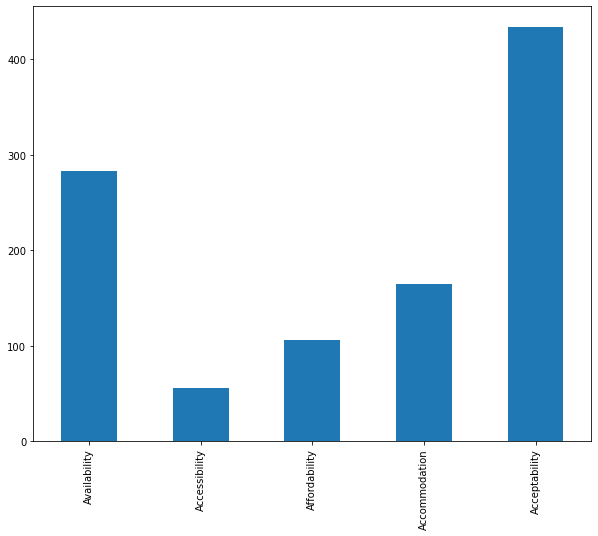

In [18]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

reviews_comments_labels.sum(axis=0).plot.bar()
plt.savefig("../../examples/visuals/reviewslabel_histogram.jpeg")

In [11]:
X = list(reviews_labels["sent_proc"])
y = reviews_comments_labels.values

In [12]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [13]:
# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
# Convert text inputs (review sentences) into embedded vectors | word embeddings
# In word embeddigns, every word is represented as an n-dimensional dense vector; words that are similar will have a similar vector
# Word embeddings techniques such as GloVe and Word2Vec are extremely efficient for converting words into dense vectors
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\ReviewsClassification\glove.6B.100d\glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
# 1 Input Layer
# 1 Embedding Layer
# 1 LSTM Layer with 128 Neurons
# 1 Output Layer with 5 Neurons for the 5 Labels in the output
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          151300    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 269,193
Trainable params: 117,893
Non-trainable params: 151,300
_________________________________________________________________
None


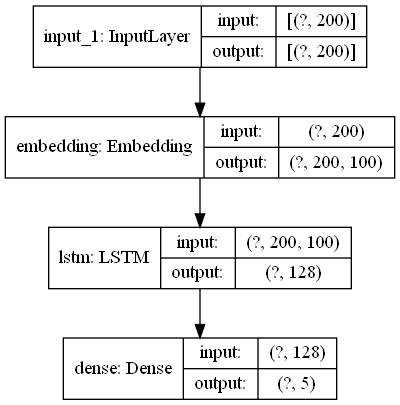

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [37]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 0s 80ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3835 - val_acc: 0.2427
Epoch 2/100
4/4 [==============================] - 0s 62ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3836 - val_acc: 0.2427
Epoch 3/100
4/4 [==============================] - 0s 59ms/step - loss: 0.3628 - acc: 0.2327 - val_loss: 0.3836 - val_acc: 0.2427
Epoch 4/100
4/4 [==============================] - 0s 58ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3836 - val_acc: 0.2427
Epoch 5/100
4/4 [==============================] - 0s 58ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3838 - val_acc: 0.2427
Epoch 6/100
4/4 [==============================] - 0s 59ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3839 - val_acc: 0.2427
Epoch 7/100
4/4 [==============================] - 0s 59ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3839 - val_acc: 0.2427
Epoch 8/100
4/4 [==============================] - 0s 60ms/step - loss: 0.3627 - acc: 0.23

4/4 [==============================] - 0s 58ms/step - loss: 0.3626 - acc: 0.2327 - val_loss: 0.3838 - val_acc: 0.2427
Epoch 64/100
4/4 [==============================] - 0s 59ms/step - loss: 0.3626 - acc: 0.2327 - val_loss: 0.3839 - val_acc: 0.2427
Epoch 65/100
4/4 [==============================] - 0s 57ms/step - loss: 0.3627 - acc: 0.2327 - val_loss: 0.3844 - val_acc: 0.2427
Epoch 66/100
4/4 [==============================] - 0s 58ms/step - loss: 0.3626 - acc: 0.2327 - val_loss: 0.3841 - val_acc: 0.2427
Epoch 67/100
4/4 [==============================] - 0s 60ms/step - loss: 0.3626 - acc: 0.2327 - val_loss: 0.3836 - val_acc: 0.2427
Epoch 68/100
4/4 [==============================] - 0s 62ms/step - loss: 0.3625 - acc: 0.2327 - val_loss: 0.3835 - val_acc: 0.2427
Epoch 69/100
4/4 [==============================] - 0s 66ms/step - loss: 0.3625 - acc: 0.2327 - val_loss: 0.3836 - val_acc: 0.2427
Epoch 70/100
4/4 [==============================] - 0s 64ms/step - loss: 0.3626 - acc: 0.2327 - 